In [139]:
#!conda install -c conda-forge python-docx seaborn

In [140]:
%load_ext autoreload
%aimport model
%autoreload 2
import pickle
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [142]:
from docplex.mp.environment import Environment
Environment().print_information()

* system is: Darwin 64bit
* Python version 3.9.13, located at: /opt/anaconda3/bin/python
* docplex is present, version is 2.25.236
* CPLEX library is present, version is 22.1.1.0, located at: /opt/anaconda3/lib/python3.9/site-packages
* pandas is present, version is 1.4.4


In [143]:
from docplex.mp.conflict_refiner import ConflictRefiner
from docplex.mp.relaxer import Relaxer

In [144]:
# redondant dans prepross_power
def year_month_date_to_string(date):
    return date.strftime('%Y%m')

def datetime_attributes(df, column, attribute=['year', 'month', 'day', 'hour', 'dayofyear', 'quarter']):
    # define generator expression of series, one for each attribute
    date_gen = (getattr(df[column].dt, i).rename(i) for i in attribute)
    return pd.concat(date_gen, axis=1)

def datetime_isocalendar(df, column, attribute=['year','week', 'weekday']):
    date_gen =  df.apply(lambda x: x[column].isocalendar(), axis=1, result_type='expand')
    date_gen = date_gen.rename(columns= dict((i,j) for i,j in enumerate(attribute)))
    date_gen['is_workday'] = date_gen['weekday'].apply(lambda  x: 1 if x<6 else 0)
    #date_gen['workday'] =  1 if date_gen['weekday']<6 else 0
    print(date_gen.head())
    return date_gen

In [145]:
def generate_Si(dataf, start, stop,name):
    d = pd.DataFrame(index=dataf.index)
    for i, (b, e) in enumerate(zip(start,stop)):
        ts = dataf.between_time(b, e)
        n = name+str(i+1)
        #try:
        d.loc[dataf.index,n] = 0

        #except:
        #    pass
        d.loc[ts.index,n] = np.where((ts['is_workday'] ==1), 1, 0)
        #d.loc[ts.index,n] = np.where((ts['is_workday'] >=0), 1, 0)
    return d.copy(True)

In [146]:
sns.set_style("whitegrid")
figure_size =[20,6]
save_dir = 'media'

In [147]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
invalid = '<>:"/\|?* '

In [148]:
plt.rcParams.update({'font.size': 22})

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [149]:
# Jupyter Notebook settings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%autosave 0
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Imports for data analysis
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 2000)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#size=25
size=22
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

/var/folders/ml/k9khjmr57qqcw3y03b7k154c0000gn/T/ipykernel_17179/3954796120.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Autosave disabled
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
filename = "ConsommationUniversite.pickle"
df = pd.read_pickle(filename)
print(df.shape)
year = df['year'].unique()
print(year)
print(df.columns)
print(max(df['Power [kW]']),max(df['Power Clipped [kW]']))

(69504, 16)
[2015 2016]
Index(['Timestamp', 'Power [kW]', 't', 'year', 'month', 'day', 'hour', 'dayofyear', 'quarter', 'week', 'weekday', 'is_workday', 'year_month', 'month_week', 'Power Clipped [kW]', 'is_peak'], dtype='object')
12442.0 2442.0


In [151]:
df['time'] = df.index

# <font color='blue'> Définition de la période d'étude </font>

Changer les valeurs de 'period_begin' et 'period_end' pour la période désirée.  Choisir la source (colonne) de puissance avec 'POWER_FOR_Pb' pour travailler.

In [152]:
#period_begin = '2015-01-12'
#period_end = '2015-01-14'
#period_end = '2015-12-31'

period_begin = '2015-01-01'
period_end = '2016-12-31'
period_end = '2015-04-01'

#an = df[df['year'] == year[0]]

# 2015-09-09 12:14:00 2015-09-09 07:14:0

Si_gen = generate_Si(df,
                 start=['08:00', '10:00', '08:00', '13:00'],
                 stop=['17:00', '15:00', '12:30', '20:00'],name='Si_')

#Si_gen = generate_Si(df,
#                 start=['07:30', '10:00', '08:00', '13:00'],
#                 stop=['17:00', '15:00', '12:30', '20:30'],name='Si_')

# Si_gen = generate_Si(df,
#                  start=['08:00','08:00','08:00','08:00' ],
#                  stop=['20:00','20:00','20:00','20:00'],name='Si_')
#print(Si_gen)

an = pd.concat([df, Si_gen], axis=1)
#an = an[(an['week'] == 3) & (an['year'] == 2015)]


POWER_FOR_Pb = 'Power [kW]'
#POWER_FOR_Pb = 'Power Clipped [kW]'
Pb = an[POWER_FOR_Pb].loc[period_begin:period_end]
idx = Pb.index
Pb = Pb.to_numpy(copy=True)
Si = Si_gen.loc[period_begin:period_end]
Si = Si.astype(float).to_numpy(copy=True)

Si_tot = np.amax(Si, axis=1)

#df2 = an.loc[period_begin:period_end]
#df2 = an
print(Pb.shape, Si.shape, Si_tot.shape)

l = Pb.shape[0]
print("maximum de Pb(t) :{m} avec T={t}".format(m=max(Pb), t=l))

arrivee = []
depart = []
for sign in Si.T:
    # JUMP
    thres = 0.5
    si = sign
    y = np.where(np.logical_and(si>-thres,si<thres), 0, 1) # ACTIVITY

    der_y = np.diff(y)
    higherPeaks = np.where(der_y>=1)[0]
    lowerPeaks = np.where(der_y<=-1)[0]
    arrivee.append(higherPeaks)
    depart.append(lowerPeaks)

    #plt.figure()
    #plt.plot(si)
    #plt.plot(higherPeaks, si[higherPeaks], 'ro')
    #plt.plot(lowerPeaks, si[lowerPeaks], 'ko')

(69504,) (69504, 4) (69504,)
maximum de Pb(t) :12442.0 avec T=69504


In [153]:
df_grp_ym = an.loc[period_begin:period_end].groupby(by='year_month').agg({'Power Clipped [kW]':'max', 'Power [kW]':'max','year':'max','month':'max','day':['nunique','idxmin','idxmax']
                                              ,'t':['min','max']
                                                   }).reset_index('year_month')
df_grp_ym.columns = df_grp_ym.columns.to_flat_index()
display(df_grp_ym)
Pb_max__m = df_grp_ym[POWER_FOR_Pb,'max'].to_numpy(copy=True)

t_min__m = df_grp_ym['t','min'].to_numpy(copy=True)
t_max__m = df_grp_ym['t','max'].to_numpy(copy=True)
print(Pb_max__m)
print(t_min__m)
print(t_max__m)

,"(year_month, )","(Power Clipped [kW], max)","(Power [kW], max)","(year, max)","(month, max)","(day, nunique)","(day, idxmin)","(day, idxmax)","(t, min)","(t, max)"
0,201501,1488.000,11488.000,2015,1,24,2015-01-08 00:14:00,2015-01-31 00:14:00,0,2303
1,201502,1690.000,11690.000,2015,2,28,2015-02-01 00:14:00,2015-02-28 00:14:00,2304,4991
2,201503,958.000,10958.000,2015,3,31,2015-03-01 00:14:00,2015-03-31 00:14:00,4992,7967
3,201504,0.000,9954.000,2015,4,30,2015-04-01 00:14:00,2015-04-30 00:14:00,7968,10847
4,201505,786.000,10786.000,2015,5,31,2015-05-01 00:14:00,2015-05-31 00:14:00,10848,13823
5,201506,1048.000,11048.000,2015,6,30,2015-06-01 00:14:00,2015-06-30 00:14:00,13824,16703
6,201507,2168.000,12168.000,2015,7,31,2015-07-01 00:14:00,2015-07-31 00:14:00,16704,19679
7,201508,830.000,10830.000,2015,8,31,2015-08-01 00:14:00,2015-08-31 00:14:00,19680,22655
8,201509,2442.000,12442.000,2015,9,30,2015-09-01 00:14:00,2015-09-30 00:14:00,22656,25535
9,201510,0.000,9906.000,2015,10,31,2015-10-01 00:14:00,2015-10-31 00:14:00,25536,28511


[11488. 11690. 10958.  9954. 10786. 11048. 12168. 10830. 12442.  9906.
 10542. 10476. 12414. 12284. 11338. 10798. 11074. 11056. 12232. 12250.
 12158. 10574. 10346. 11514.]
[    0  2304  4992  7968 10848 13824 16704 19680 22656 25536 28512 31392
 34368 37344 40128 43104 45984 48960 51840 54816 57792 60672 63648 66528]
[ 2303  4991  7967 10847 13823 16703 19679 22655 25535 28511 31391 34367
 37343 40127 43103 45983 48959 51839 54815 57791 60671 63647 66527 69503]


# <font color='blue'> Définition des Paramètres du modèle </font>

In [154]:
print('Set problem parameters')
n_ev = 1600.0

# Prius 4.4kWh, Leaf 24kWh
soc_max = 48#0.8*24*n_ev
soc_min = 9#0.2*4.4*n_ev
print("{mi} <= SOC <= {ma}".format(mi=soc_min, ma=soc_max))

params = {
    # Variables	Descriptions	Unités
    'C__E': 0.003830, # Coût de l'énergie $/kW
    'C__P': 14.677, # Coût de la puissance $/kW
    'C__b_n': np.tile(np.array([[0.0196], [0.268]]),4), # Coût de l'infrastructure N $/delta_t
    'SOCmin': soc_min,  # État de charge minimum des véhicules électriques	kWh
    'SOCmax': soc_max,  # État de charge maximum des véhicules électriques	kWh
    'Pch_min': 0,#(4.4*(15/60)),  # Puissance de charge minimum 	kW
    'Pdis_min': 0,#(4.4*(15/60)),  # Puissance de décharge minimum	kW
    'Pch_max_n': [10, 63], #[bn*7.5, bn*50.0],  # Puissance de charge maximum en utilisant les bornes de type n	kW
    'Pdis_max_n': [10, 63], #[bn*5.0, bn*40.0],  # Puissance de décharge maximum en utilisant les bornes de type n	kW
    'beta_ch': 0.93,  # Efficacité de charge_
    # 	%
    'beta_dis': 0.93,  # Efficacité de décharge	%
    'NEVs': n_ev,  # Nombre de véhicules électriques	Qté
    'Rut': [0.42, 0.01, 0.19, 0.38],  # Ratio d’utilisateurs avec le profil i	%
    'Rut_eps': 0.01,
    'delta_t': 15 / 60,  # 15mins
    'MAX_OPTIM': 1e7,  # Facteur majorant du programme d'optimisation

    'Pb': Pb,  # Puissance appelée par le bâtiment appelée à l’instant t	kW
    'Pb_max__m': Pb_max__m, # Puissance maximale du bâtiment par mois
    'P_souscrite' : 10000, # Puissance souscrite avec Hydro-Québec
    'Si': Si, #1, Si le profil d’utilisateur est raccordé à une borne à l’instant t

    't_min__m': t_min__m, # indice du premier échantillon t du mois m
    't_max__m': t_max__m, # indice du dernier échantillon t du mois m

    'arrivee':arrivee, # indices des échantillons t d'arrivées sur la période T
    'depart':depart, # indices des échantillons t de départ sur la période T
}

Set problem parameters
9 <= SOC <= 48


In [155]:
#%aimport model
#more: https://ibmdecisionoptimization.github.io/docplex-doc/mp/docplex.mp.solution.html#docplex.mp.solution.SolveSolution
mdl = model.ModelShaving('V2B', params=params)
mdl.problem_variables()

mdl.problem_constraints() #

# [mdl.add_constraint(mdl.Nborne__n_i[n, i] >= 1) for n in mdl.ens['N'] for i in mdl.ens['I']]
#
# [mdl.add_constraint(mdl.sum(mdl.Nborne__n_i[n, i] for n in mdl.ens['N'])
#                     <=
#                     mdl.sum(mdl.Nborne__n_i) * (mdl.params['Rut'][i-1] + mdl.params['Rut_eps'])) for i in mdl.ens['I'] ]
#
# [mdl.add_constraint(mdl.sum(mdl.Nborne__n_i[n, i] for n in mdl.ens['N'])
#                     >=
#                     mdl.sum(mdl.Nborne__n_i) * (mdl.params['Rut'][i-1] - mdl.params['Rut_eps'])) for i in mdl.ens['I'] ]

#mdl.add_kpi(mdl.sum(mdl.Nborne__n_i), 'Nborne')


#[mdl.add_constraint(mdl.Pabs__n_i_t[n,i,t] == mdl.abs(mdl.Pess__n_i_t[n, i, t]))
# for n in mdl.ens['N'] for i in mdl.ens['I'] for t in mdl.ens['T'] ]

# [mdl.add_constraint(mdl.Pabs__n_i_t[n,i,t] / max(mdl.params['Pch_max_n'][n-1], mdl.params['Pdis_max_n'][n-1])
#                     <= mdl.Nborne__n_i[n, i])
#   for n in mdl.ens['N'] for i in mdl.ens['I'] for t in mdl.ens['T'] ]



#mdl.problem_constraint_prevent_simultaneous_charge_and_discharge_i_t()
#mdl.problem_constraint_Pr__n_i_t()

# ceci est nouveau
#mdl.problem_constraint_uc_soc_ramp_up_and_soc_ramp_down() # autre façon pour le SOC mais sans ch & desch
#mdl.problem_constraint_SOC__n_i_t_latch_on() # Le faire pour charge/discharge ?!


#mdl.problem_constraint_uc_connexion_deconnection() # actuellement non utilisé (remplacé par arrivee , depart )


#mdl.ctr_Pr__t = mdl.problem_constraint_Pr__t()

#mdl.problem_constraint_SOC__n_i_t() # Bloque les autres, mais sans delta delta_ch/dis__n_i_t
#mdl.problem_constraint_SOC__v2_n_i_t()

# [mdl.add_range(#lb=mdl.sum(mdl.Nborne__n_i)*mdl.params['Rut'][i-1],
#                 lb=1,
#               expr=mdl.sum(mdl.Nborne__n_i[n, i] for n in mdl.ens['N']),
#               ub=mdl.sum(mdl.Nborne__n_i[n, i] for n in mdl.ens['N'] for i in mdl.ens['I'])*mdl.params['Rut'][i-1]) for i in mdl.ens['I']]


print('\n')
mdl.print_information()
solus = mdl.solve(log_output=True)
assert solus is not None, "!!! Solve of the model fails"
print("*"*50)
print("Obj", mdl.solution.get_objective_value())
#mdl.print_solution(print_zeros=False)
print("-"*50)
mdl.report()
print("-"*50)
print('end')
#with open('solution.pickle', mode='wb') as f:
#    pickle.dump(solus, f)
#filename = Path(save_dir,'solution.json')
#with open('solution.json', mode='wb') as f:
#    solus.export(f,format='json')


{'utilsateur': 4, 'borne': 2, 'instant': 69504, 'mois': 24, 'I': range(1, 5), 'N': range(1, 3), 'T': range(0, 69504), 'M': range(0, 24)}
0 0 2304
1 0 2688
2 0 2976
3 0 2880
4 0 2976
5 0 2880
6 0 2976
7 0 2976
8 0 2880
9 0 2976
10 0 2880
11 0 2976
12 0 2976
13 0 2784
14 0 2976
15 0 2880
16 0 2976
17 0 2880
18 0 2976
19 0 2976
20 0 2880
21 0 2976
22 0 2880
23 0 2976
0 0 2304
1 0 2688
2 0 2976
3 0 2880
4 0 2976
5 0 2880
6 0 2976
7 0 2976
8 0 2880
9 0 2976
10 0 2880
11 0 2976
12 0 2976
13 0 2784
14 0 2976
15 0 2880
16 0 2976
17 0 2880
18 0 2976
19 0 2976
20 0 2880
21 0 2976
22 0 2880
23 0 2976


Model: V2B
 - number of variables: 4934937
   - binary=764544, integer=8, continuous=4170385
 - number of constraints: 1677736
   - linear=1538728, indicator=139008
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Presolve has eliminated 645432 rows and 4676368 columns...


cr = ConflictRefiner()
crr = cr.refine_conflict(mdl, display=True)
print("="*50)
rx = Relaxer()
rs = rx.relax(mdl)
rx.print_information()
#rs.display()
print("+"*50)

In [156]:
df_Nborne__n_i = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Nborne__n_i,
                                 index='i', columns='n').astype(int)
display(df_Nborne__n_i)

n,1,2
i,,
1,0,0
2,0,0
3,0,0
4,0,0


Setting constraint priorities explicitly is the most basic way to control relaxation, but there are others. A _function_ can be used: the relaxer will call the function for each constraint to determine its priority. Possible values are:

  - relaxable priorities: VERY_LOW, LOW, MEDIUM, HIGH, VERY_HIGH
  - non-relaxable priority: MANDATORY

Constraints with higher priority are less likely to be relaxed than constraints with lower priorities. Still, relaxation of a high-priority constraint cannot be ruled out, if it is the only way to provide a relaxed solution.

In [157]:
dk = pd.DataFrame({'Pb batiment': mdl.params['Pb'],
                   'Pr reseau': solus.get_value_list(mdl.Pr__t),
                   #'P charge totale': solus.get_value_list(mdl.Pch_tot__t),
                   #'P décharge totale': solus.get_value_list(mdl.Pdis_tot__t),
                   'P ESS totale': solus.get_value_list(mdl.Pess__t),
                   'Si': Si_tot,
                   #'t':idx
                   }
                  ).set_index(idx)
#dk.to_csv('resultats.csv')

In [158]:
#dk['Pr reseau'].plot()

In [159]:
mensuel = pd.DataFrame({'Pr': solus.get_value_list(mdl.Pr_max__m),
                        'Pess': solus.get_value_list(mdl.Pess_max__m),
                        'Em': solus.get_value_list(mdl.E__m),
                        'Cout Infra': solus.get_value_list(mdl.cout_infra_m),
                   #'t':idx
                   }
                  )#.set_index()

mensuel['Cout Energie'] = mensuel['Em'] * mdl.params['C__E']
mensuel['Cout Puissance'] = mensuel['Pr'] * mdl.params['C__P']

zz = mensuel
zz['Cout Total'] = zz[['Cout Infra', 'Cout Energie', 'Cout Puissance']].sum(axis=1)
zy = zz.sum(axis=0)
zy = zy.to_frame(name='Somme')
mensuel =  pd.concat([zz.T,zy],axis=1).T


display(mensuel)

,Pr,Pess,Em,Cout Infra,Cout Energie,Cout Puissance,Cout Total
0,11153.211,1039.599,4410215.799,13583.923,16891.127,163695.685,194170.734
1,11153.211,1039.599,5164445.449,15847.910,19779.826,163695.685,199323.421
2,11153.211,1039.599,5772909.898,17545.901,22110.245,163695.685,203351.830
3,11153.211,1039.599,5537469.898,16979.904,21208.510,163695.685,201884.098
4,11153.211,1039.599,5772909.898,17545.901,22110.245,163695.685,203351.830
5,11153.211,1039.599,5537469.898,16979.904,21208.510,163695.685,201884.098
6,11153.211,1039.599,5772909.898,17545.901,22110.245,163695.685,203351.830
7,11153.211,1039.599,5772909.898,17545.901,22110.245,163695.685,203351.830
8,11153.211,1039.599,5537469.898,16979.904,21208.510,163695.685,201884.098
9,11153.211,1039.599,5772909.898,17545.901,22110.245,163695.685,203351.830


In [160]:
df_SOC__n_i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.SOC__n_i_t, index='t', columns=['n', 'i'])


df_Pess__n_i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pess__n_i_t, index='t', columns=['n', 'i'])

#print(df_Pch__i_t)
#print(df_Pdis__i_t)
#df_SOC__n_i_t.rename(mapper=lambda x: f'N_{x}', axis='columns', level=0, inplace=True)
#df_SOC__n_i_t.rename(mapper=lambda x: f'I_{x}', axis='columns', level=1, inplace=True)
#print(df_SOC__n_i_t)

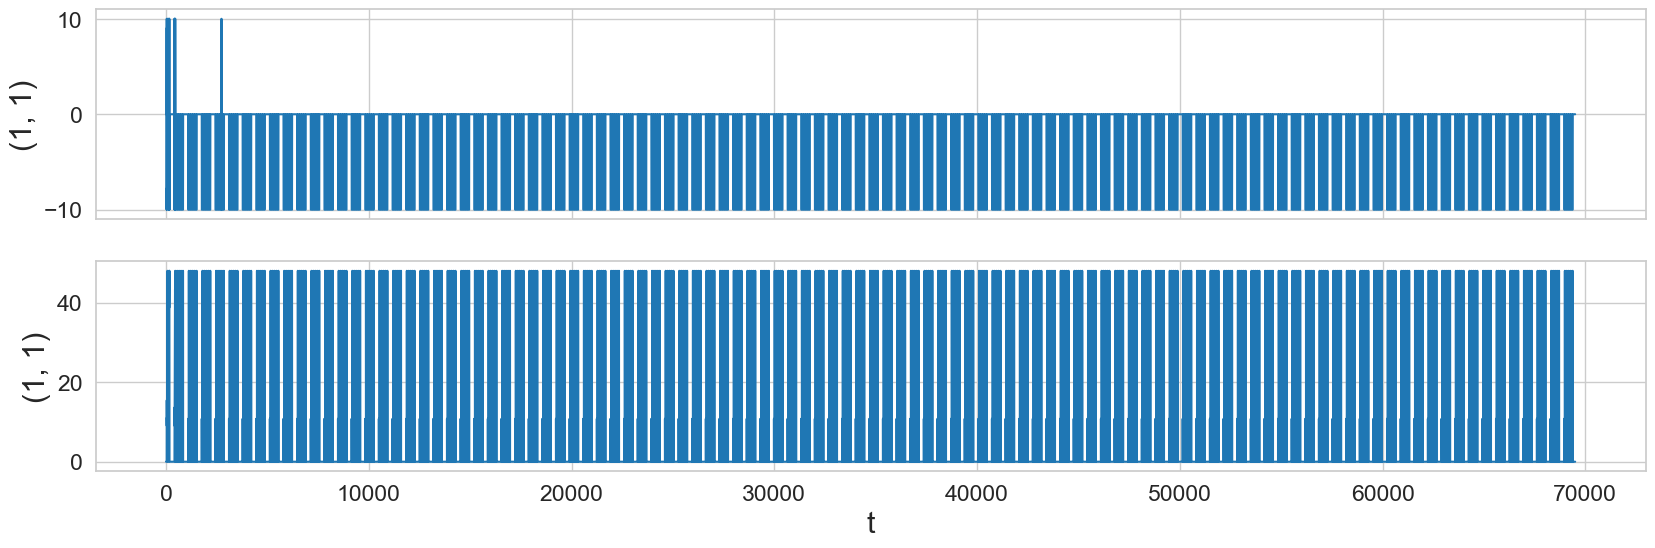

In [161]:
fig, axs = plt.subplots(nrows=2, figsize=figure_size, sharex=True)
g = sns.lineplot(x='t', y=(1,1), data=df_Pess__n_i_t,  ax=axs[0],color='tab:blue')
h = sns.lineplot(x='t', y=(1,1), data=df_SOC__n_i_t,  ax=axs[1],color='tab:blue')

In [162]:
dk['bat_Pess'] = dk['Pb batiment']+dk['P ESS totale']

/var/folders/ml/k9khjmr57qqcw3y03b7k154c0000gn/T/ipykernel_17179/1892874593.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  g = dk[name].plot(figsize=figure_size,subplots=True, ax=ax, sharex=True)


Text(0.5, 1.0, "Répartition des Puissances [kW] en fonction de l'ensemble des connections Si")

Text(0.5, 0, 'temps [(Y)-M-J H]')

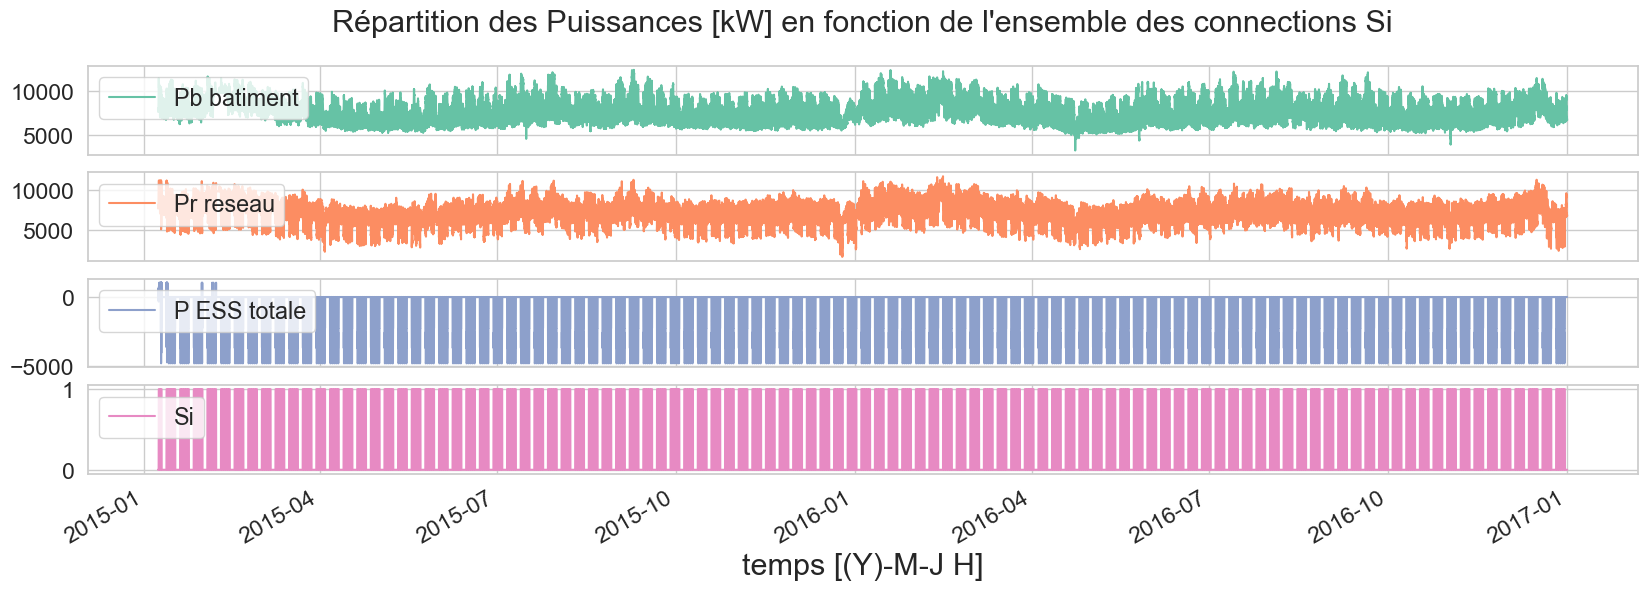

In [163]:
name = ['Pb batiment','Pr reseau','P ESS totale', 'Si']


title = "Répartition des Puissances [kW] en fonction de l'ensemble des connections Si"
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=figure_size, sharex=True)
fig1 = ax.get_figure()
g = dk[name].plot(figsize=figure_size,subplots=True, ax=ax, sharex=True)
for i in g:
    i.legend(loc='upper left')
g[0].set_title(title)
g[-1].set_xlabel('temps [(Y)-M-J H]')

filename = title
for char in invalid:
	filename = filename.replace(char, '_')
filename = Path(save_dir,filename+'.png')

plt.show()

fig1.savefig(filename, format='png', dpi=300, bbox_inches='tight')

Text(0.5, 0, 'temps [(Y)-M-J H]')

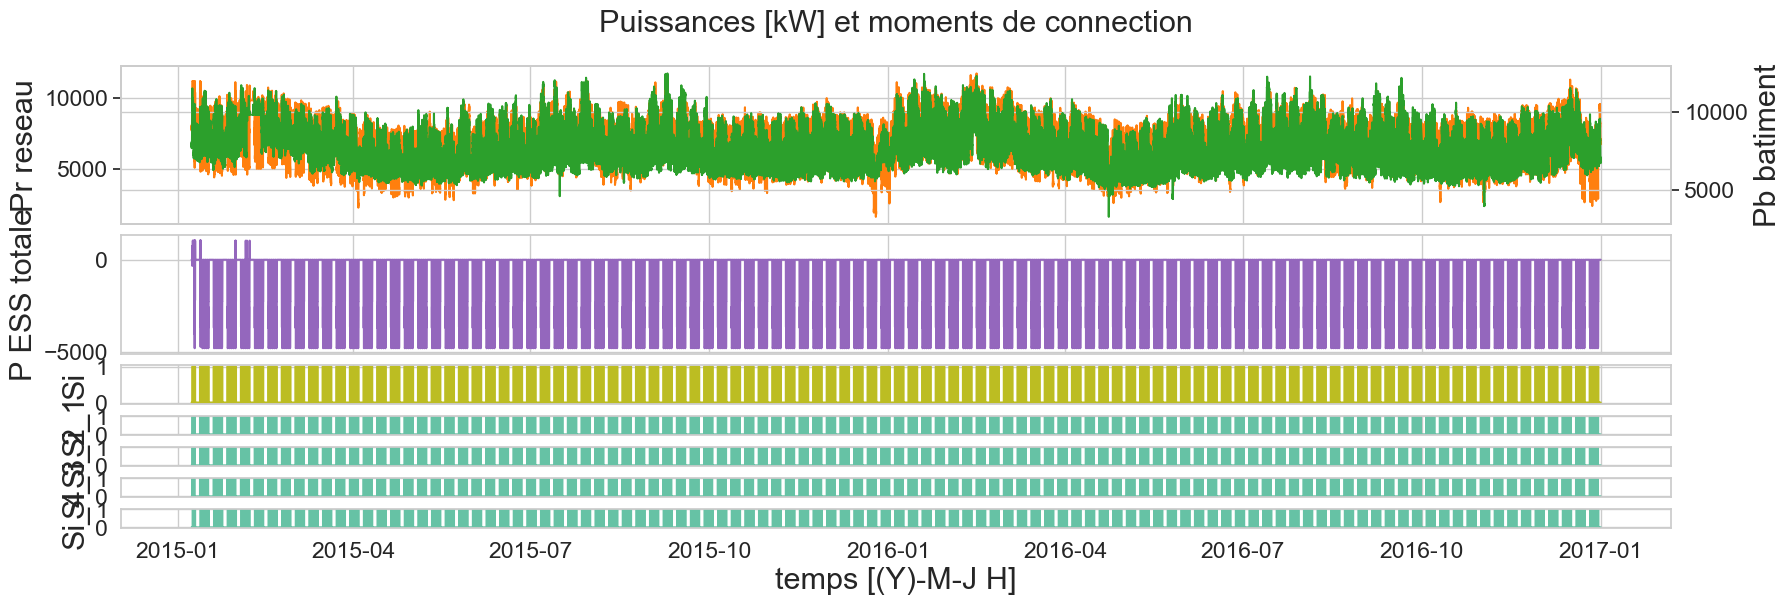

In [164]:
title = 'Puissances [kW] et moments de connection'
en = pd.DataFrame(mdl.params['Si'], columns=['Si_1', 'Si_2','Si_3','Si_4'])
en['t'] = idx
sns.set_style("whitegrid")

fig, axs = plt.subplots(nrows=7, figsize=figure_size, sharex=True,
                        gridspec_kw={'height_ratios': [2.0, 1.5, 0.5, 0.25, 0.25, 0.25, 0.25]})

g = sns.lineplot(x=dk.index, y='Pr reseau', estimator='max', data=dk,  ax=axs[0], color='tab:orange')
ax2 = g.twinx()
h = sns.lineplot(x=dk.index, y='Pb batiment', estimator='max', data=dk, ax=ax2, color='tab:green',dashes=True)

#g = sns.lineplot(x=dk.index, y='P décharge totale', estimator='max', data=dk,  ax=axs[1], color='tab:purple', dashes=True)
#ax2 = g.twinx()
#h = sns.lineplot(x=dk.index, y='P charge totale', estimator='max', data=dk, ax=ax2, color='tab:pink', dashes=True)


g = sns.lineplot(x=dk.index, y='P ESS totale', estimator='max', data=dk,  ax=axs[1], color='tab:purple', dashes=True)

#g.set_yticklabels(g.get_yticklabels(), rotation=45)
#h.set_yticklabels(h.get_yticklabels(), rotation=45)

#g.tick_params(axis='y', labelrotation = 45)

what = 't'
g = sns.lineplot(x=dk.index, y='Si', estimator='max', data=dk, ax=axs[2], drawstyle="steps", color="tab:olive")
g = sns.lineplot(x=what, y='Si_1', estimator='max', data=en, ax=axs[3], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_2', estimator='max', data=en, ax=axs[4], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_3', estimator='max', data=en, ax=axs[5], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_4', estimator='max', data=en, ax=axs[6], drawstyle="steps")
axs[6].set_xlabel('temps [(Y)-M-J H]')
for a in range(3, 7):
    axs[a].set_yticks([0, 1])

filename = title
for char in invalid:
	filename = filename.replace(char, '_')
filename = Path(save_dir,filename+'.png')

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=300, bbox_inches='tight')


2015-09-09 12:14:00 2016-02-15 07:59:00


Text(2015-01-08 00:14:00, 12442.0, 'Puissance Maximale  avant (sans V2B): 12442.0kW , après (avec V2B): 11698.0kW ')

Text(0, 0.5, 'Puissance [kW]')

Text(0.5, 0, 'temps [(Y)-M-J H]')

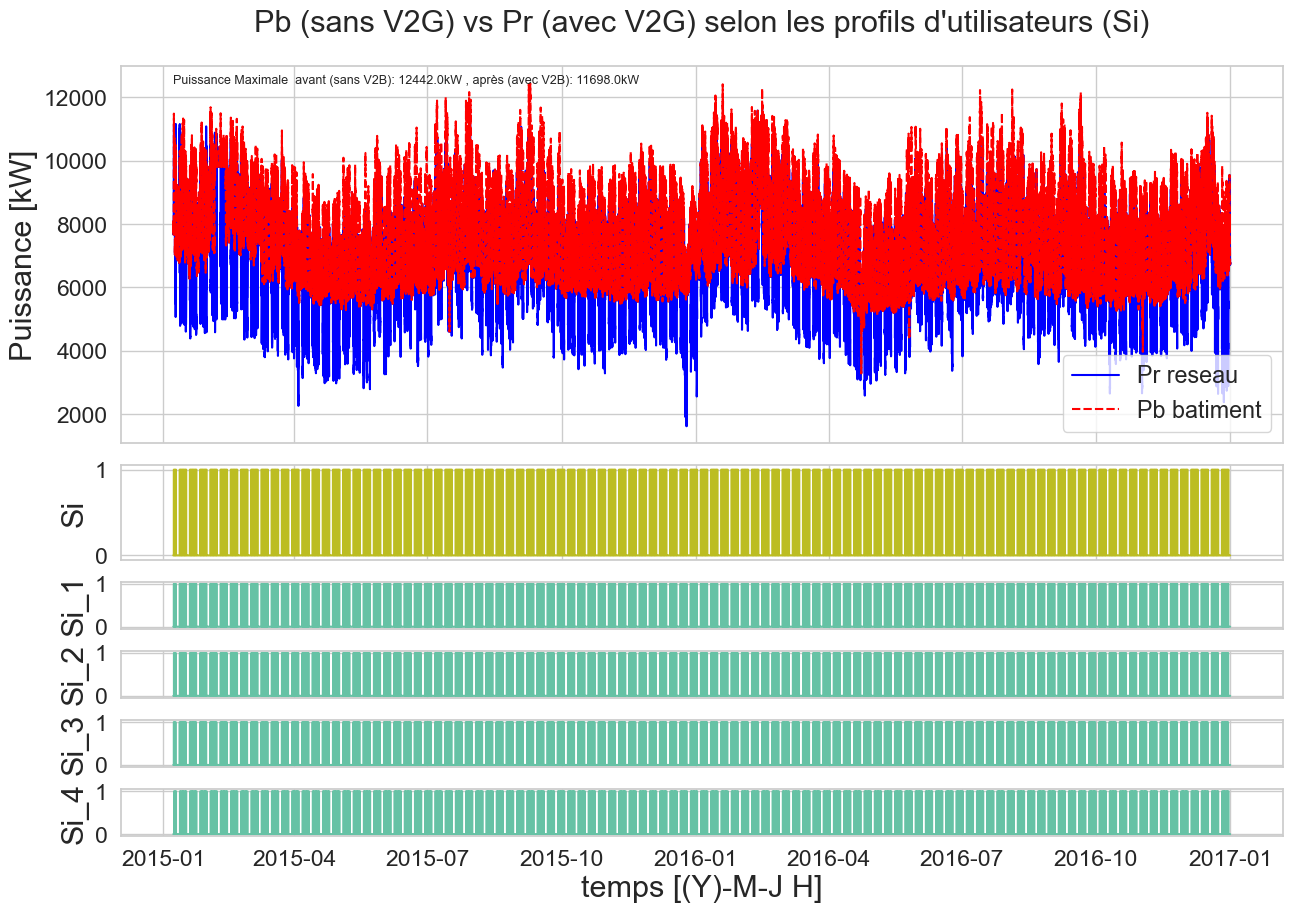

Puissance Maximale  avant (sans V2B): 12442.0kW , après (avec V2B): 11698.0kW 


In [165]:
text = 'Puissance Maximale  avant (sans V2B): {b}kW , après (avec V2B): {r}kW '.format(b=dk['Pb batiment'].max(), r=dk['Pr reseau'].max() )

idb_max = dk['Pb batiment'].idxmax()
idr_max = dk['Pr reseau'].idxmax()
print(idb_max, idr_max)
# 2015-09-09 12:14:00 2015-09-09 07:14:0     :: Mercredi

title = "Pb (sans V2G) vs Pr (avec V2G) selon les profils d'utilisateurs (Si)"
en = pd.DataFrame(mdl.params['Si'], columns=['Si_1', 'Si_2','Si_3','Si_4'])
en['t'] = idx
sns.set_style("whitegrid")

fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(15,10), sharex=True, gridspec_kw={'height_ratios': [2, 0.5,0.25, 0.25, 0.25, 0.25]})
g = sns.lineplot(data=dk[['Pr reseau','Pb batiment']],  ax=axs[0], palette=['b','r'])
axs[0].text(dk.index[0], dk['Pb batiment'][idb_max], text, fontsize=9)
axs[0].set_ylabel('Puissance [kW]')
g = sns.lineplot(x=dk.index, y='Si', estimator='max', data=dk, ax=axs[1], drawstyle="steps", color='tab:olive')
g = sns.lineplot(x=what, y='Si_1', estimator='max', data=en, ax=axs[2], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_2', estimator='max', data=en, ax=axs[3], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_3', estimator='max', data=en, ax=axs[4], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_4', estimator='max', data=en, ax=axs[5], drawstyle="steps")
axs[5].set_xlabel('temps [(Y)-M-J H]')
for a in range(1,6):
    axs[a].set_yticks([0, 1])

filename = title
for char in invalid:
	filename = filename.replace(char, '_')
filename = Path(save_dir,filename+'.png')

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=300, bbox_inches='tight')
print(text)

[(0.0, 50.4)]

[(0.0, 50.4)]

[(0.0, 50.4)]

[(0.0, 50.4)]

[(0.0, 50.4)]

[(0.0, 50.4)]

[(0.0, 50.4)]

[(0.0, 50.4)]

media/EtatdechargedesbatterieskWhÉnergieSOCnit.png


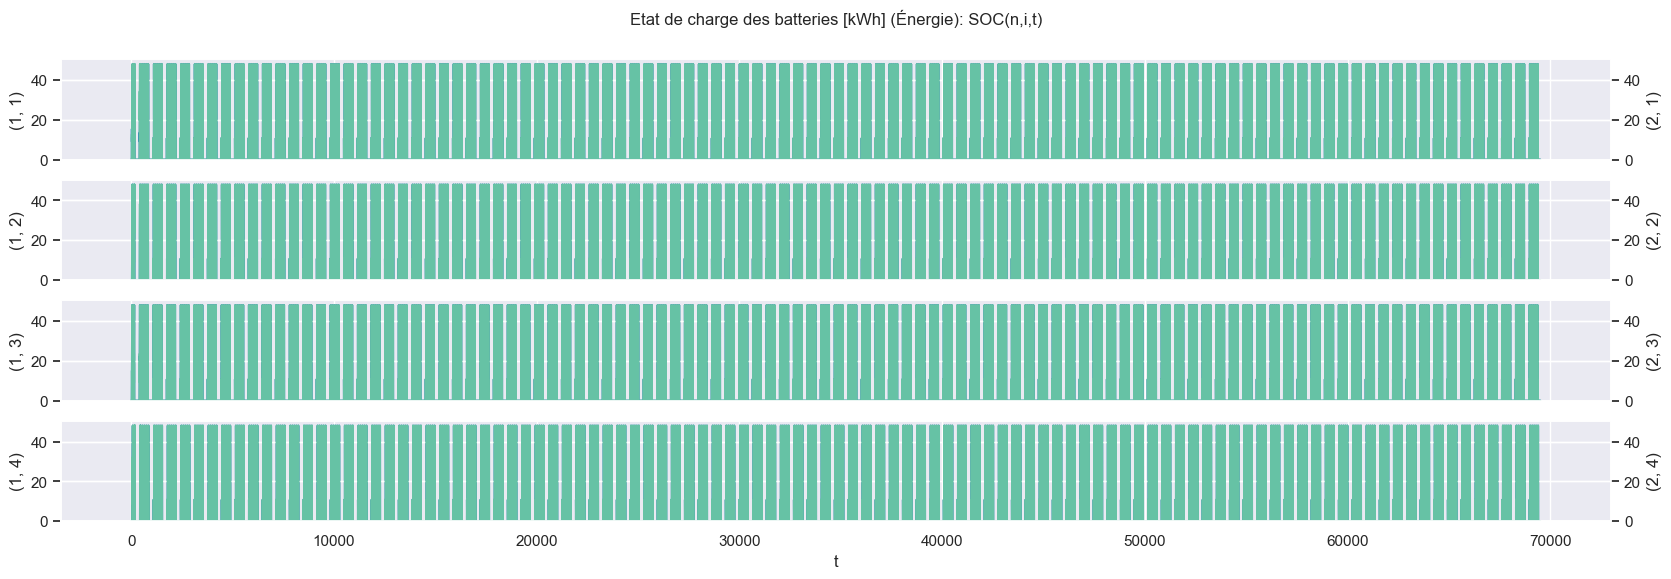

In [166]:
# Error Bands + valeur maximale des mois
title = "Etat de charge des batteries [kWh] (Énergie): SOC(n,i,t)"
what= 't'
#sns.set_theme(style="ticks")
sns.set_theme(style="darkgrid",palette='Set2')

fig, axs = plt.subplots(nrows=4, figsize=figure_size, sharex=True)
g = sns.lineplot(x=what, y=(1,1), estimator='max', data=df_SOC__n_i_t,  ax=axs[0],color='tab:blue')
g.set(ylim=(0, None))
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,1), estimator='max', data=df_SOC__n_i_t, ax=ax2)
h.set(ylim=(0, None))
g = sns.lineplot(x=what, y=(1,2), estimator='max', data=df_SOC__n_i_t, ax=axs[1],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,2), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g.set(ylim=(0, None))
h.set(ylim=(0, None))
g = sns.lineplot(x=what, y=(1,3), estimator='max', data=df_SOC__n_i_t, ax=axs[2],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,3), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g.set(ylim=(0, None))
h.set(ylim=(0, None))
g = sns.lineplot(x=what, y=(1,4), estimator='max', data=df_SOC__n_i_t, ax=axs[3],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,4), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g.set(ylim=(0, None))
h.set(ylim=(0, None))

#filename = title
#for char in invalid:
#	filename = filename.replace(char, '_')
#filename = filename+'.png'
#filename = Path(save_dir,filename)

s = ''.join(c for c in title if c.isalnum())
filename = s+'.png'
filename = Path(save_dir,filename)


print(filename)
axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=200, bbox_inches='tight')

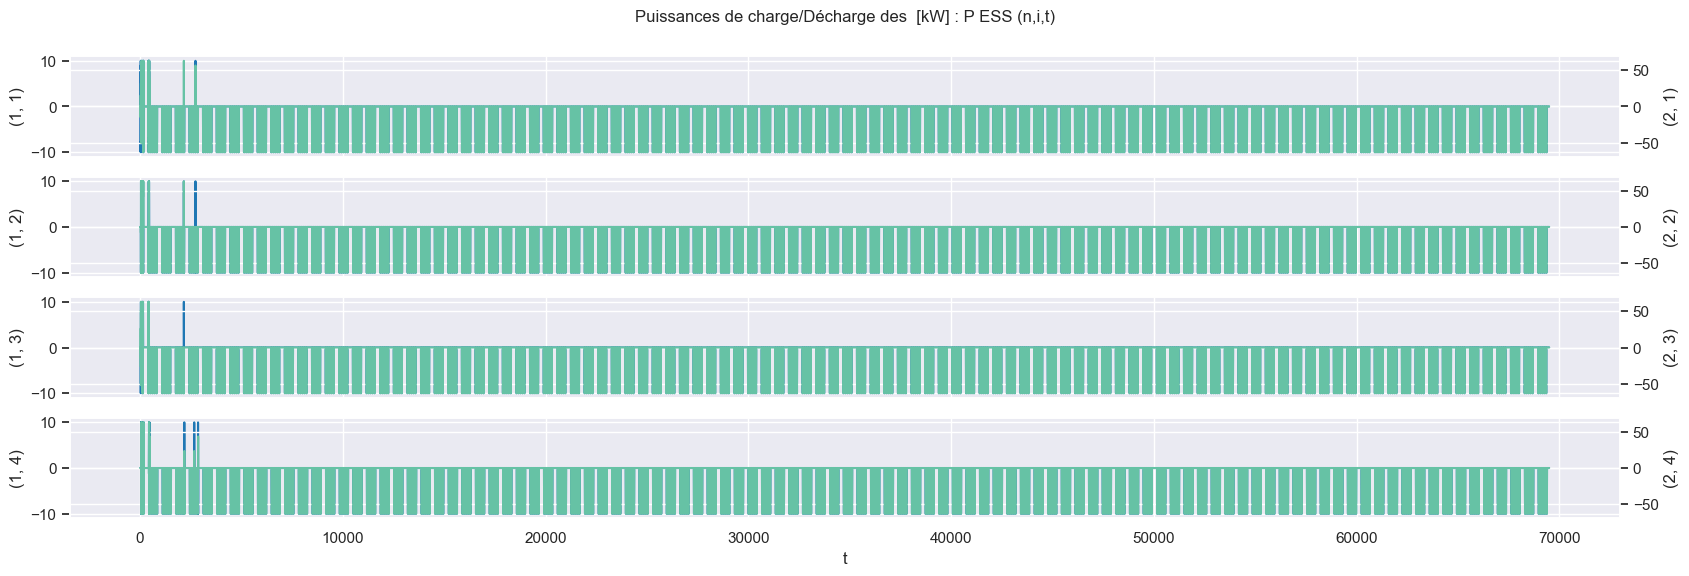

In [167]:
# Error Bands + valeur maximale des mois
title = "Puissances de charge/Décharge des  [kW] : P ESS (n,i,t)"
what= 't'
#sns.set_theme(style="ticks")
sns.set_theme(style="darkgrid",palette='Set2')

fig, axs = plt.subplots(nrows=4, figsize=figure_size, sharex=True)
g = sns.lineplot(x=what, y=(1,1), estimator='max', data=df_Pess__n_i_t,  ax=axs[0],color='tab:blue')
#g.set(ylim=(0, None))
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,1), estimator='max', data=df_Pess__n_i_t, ax=ax2)
#h.set(ylim=(0, None))
g = sns.lineplot(x=what, y=(1,2), estimator='max', data=df_Pess__n_i_t, ax=axs[1],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,2), estimator='max', data=df_Pess__n_i_t, ax=ax2)
#g.set(ylim=(0, None))
#h.set(ylim=(0, None))
g = sns.lineplot(x=what, y=(1,3), estimator='max', data=df_Pess__n_i_t, ax=axs[2],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,3), estimator='max', data=df_Pess__n_i_t, ax=ax2)
#g.set(ylim=(0, None))
#h.set(ylim=(0, None))
g = sns.lineplot(x=what, y=(1,4), estimator='max', data=df_Pess__n_i_t, ax=axs[3],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,4), estimator='max', data=df_Pess__n_i_t, ax=ax2)
#g.set(ylim=(0, None))
#h.set(ylim=(0, None))

filename = title
for char in invalid:
	filename = filename.replace(char, '_')
filename = Path(save_dir,filename+'.png')

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=300, bbox_inches='tight')


Text(0.5, 1.0, 'Puissances de charge/décharge [kW] : Pess(n,i,t)')

n  i
1  1   10.000
   2   10.000
   3   10.000
   4   10.000
2  1   63.000
   2   63.000
   3   63.000
   4   63.000
dtype: float64


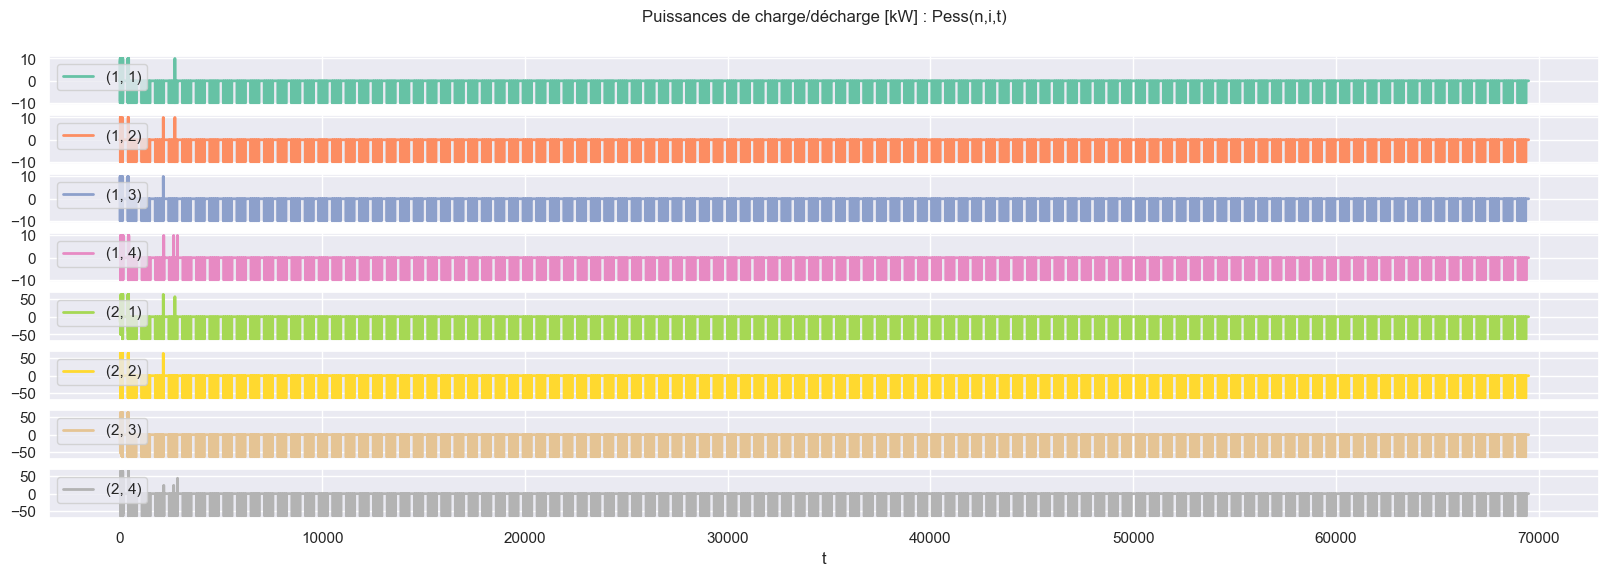

In [168]:
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pess__n_i_t, index='t', columns=['n', 'i'])
g = df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
g[0].set_title('Puissances de charge/décharge [kW] : Pess(n,i,t)')
for i in g:
    i.legend(loc='upper left')
print(df_var.max())

In [169]:
peak_label = 'is_peak'
above_threshold_label = 'is_above_threshold_label'
timestamp = 'Timestamp'
res = dk.copy(True)
print(res.shape)
res[timestamp] = res.index
res[peak_label] = np.where(res['Pb batiment']>=10000, 1,0)
res[above_threshold_label] = np.where(res['Pr reseau']>=10000, 1,0)

df_time = datetime_attributes(res,column=timestamp)
df_iso = datetime_isocalendar(res,column=timestamp)
dfk = pd.concat([res, df_time, df_iso[['week','weekday','is_workday']]],axis=1)
dfk['year_month'] = year_month_date_to_string(dfk.index)
dfk['month_week'] = 100*dfk['month']+dfk['week']


rep_heure_avant= (15/60) * pd.crosstab(dfk.year, dfk.month, aggfunc='sum', values=dfk[peak_label], normalize=False)
rep_heure_apres= (15/60) * pd.crosstab(dfk.year, dfk.month, aggfunc='sum', values=dfk[above_threshold_label], normalize=False)

rep_heure_avant['V2B'] = 'Avant'
rep_heure_avant = rep_heure_avant.set_index('V2B', append=True)
rep_heure_apres['V2B'] = 'Apres'
rep_heure_apres = rep_heure_apres.set_index('V2B', append=True)
rep_heure = pd.concat([rep_heure_avant, rep_heure_apres])
#display(rep_heure)

rep_heure = rep_heure.sort_index(ascending=False)
display(rep_heure)

(69504, 5)
                     year  week  weekday  is_workday
index                                               
2015-01-08 00:14:00  2015     2        4           1
2015-01-08 00:29:00  2015     2        4           1
2015-01-08 00:44:00  2015     2        4           1
2015-01-08 00:59:00  2015     2        4           1
2015-01-08 01:14:00  2015     2        4           1


month            1       2      3     4      5      6       7      8       9    10     11     12
year V2B                                                                                        
2016 Avant 214.250 236.000 76.000 6.750 33.750 67.000 158.750 82.000  89.000 8.250  6.750 75.000
     Apres  28.500  50.500  8.750 0.000  0.250  3.250   8.250  3.000   3.750 0.000  0.000 14.500
2015 Avant  83.750 170.750 11.750 0.000 16.750 37.750 149.750 29.000 148.000 0.000 13.250  4.250
     Apres  37.000  17.000  0.250 0.000  0.000  0.000  15.000  0.000   7.500 0.000  0.000  0.000

[Text(0, 0.5, '2016-Avant'),
 Text(0, 1.5, '2016-Apres'),
 Text(0, 2.5, '2015-Avant'),
 Text(0, 3.5, '2015-Apres')]

Text(0.5, 1.0, 'Répartition annuelle des temps de pics V2B [h]')

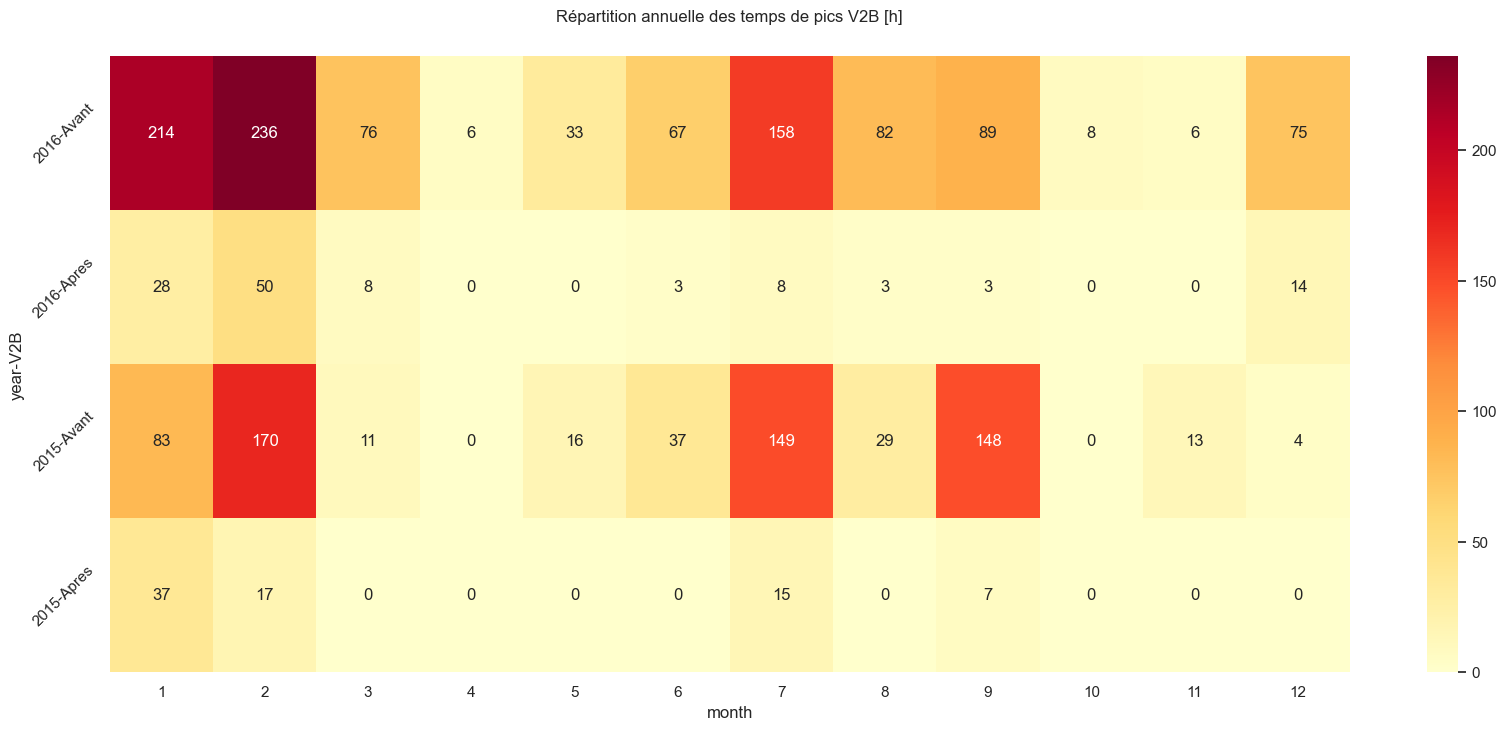

In [170]:
title = "Répartition annuelle des temps de pics V2B [h]"
rep_heure = rep_heure.astype(int)
g = sns.heatmap(rep_heure,cmap="YlOrRd", annot=True, cbar=True, fmt='.0f')
g.set_yticklabels(g.get_yticklabels(), rotation=45)

for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.title(title)
plt.show()
fig.savefig(filename, format='png', dpi=300, bbox_inches='tight')

In [171]:
rep_perc_avant= (100) * pd.crosstab(dfk.year, dfk.month, aggfunc='sum', values=dfk[peak_label], normalize=True)
rep_perc_apres= (100) * pd.crosstab(dfk.year, dfk.month, aggfunc='sum', values=dfk[above_threshold_label], normalize=True)

In [172]:
from docx import Document

def doc_table(doc, tab):
    # add a table to the end and create a reference variable
    # extra row is so we can add the header row
    t = doc.add_table(tab.shape[0]+1, tab.shape[1]+1)
    #t.style = 'LightShading-Accent1'
    # add the header rows.
    t.cell(0,0).text = 'index'
    for j in range(tab.shape[-1]):
        t.cell(0,j+1).text = str(tab.columns[j])
    # add the rest of the data frame
    for i in range(tab.shape[0]):
        print(i)
        r = tab.index[i]
        t.cell(i+1,0).text = str(r)
        for j in range(tab.shape[-1]):
            t.cell(i+1,j+1).text = str(tab.values[i,j])

In [173]:
from docx.enum.text import WD_BREAK
from docx.text import run
doc = Document()
doc.add_heading('Résumé des informations du problème', 0)

p = doc.add_paragraph('Rborne[n,i]')
t_df = pd.DataFrame(mdl.Rborne__n_i)
doc_table(doc=doc, tab=t_df)
p = doc.add_paragraph('')
doc.add_page_break()

doc.add_paragraph('répartition annuelle avant V2B ')
t_rows = rep_perc_avant.round(decimals=1)
doc_table(doc=doc, tab=t_rows)
p = doc.add_paragraph('')
doc.add_paragraph('répartition annuelle après V2B ')
t_rows = rep_perc_apres.round(decimals=1)
doc_table(doc=doc, tab=t_rows)
p = doc.add_paragraph('')


doc.add_paragraph('répartition annuelle des temps de pics avant V2B [h]')
t_rows = rep_heure_avant.round(decimals=0).astype(int)
doc_table(doc=doc, tab=t_rows)
p = doc.add_paragraph('')

doc.add_paragraph('répartition annuelle des temps de pics après V2B [h]')
t_rows = rep_heure_apres.round(decimals=0).astype(int)
doc_table(doc=doc, tab=t_rows)
p = doc.add_paragraph('')

doc.add_page_break()
doc.add_paragraph('Données du Mois')
doc_table(doc=doc, tab=mensuel.round(decimals=2))

# save the doc
doc.save(Path(save_dir, 'tables.docx'))

0
1


0
1


0
1


0
1


0
1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


## END OF MAIN

## TROUBLESHOOTING

In [174]:
df_Pch__i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pch_demand_i_t,
                                 index='t', columns='i', prefix='Pch__i_t__')
df_Pdis__i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pch_demand_i_t,
                                 index='t', columns='i', prefix='Pdis__i_t__')

Text(0.5, 1.0, 'Puissances de charge [kW] : Pch(n,i,t)')

n  i
1  1    0
   2    0
   3    0
   4    0
2  1    0
   2    0
   3    0
   4    0
dtype: int64


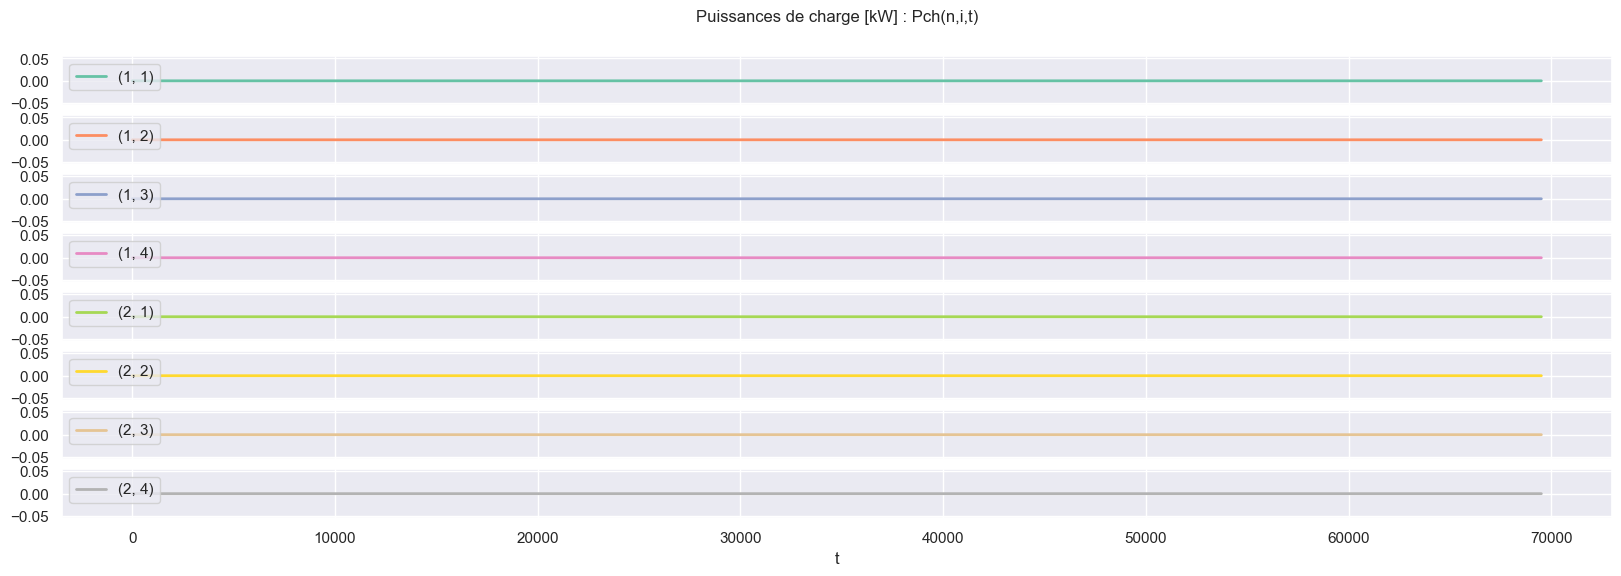

In [175]:
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pch__n_i_t, index='t', columns=['n', 'i'])
g = df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
g[0].set_title('Puissances de charge [kW] : Pch(n,i,t)')
for i in g:
    i.legend(loc='upper left')
print(df_var.max())

Text(0.5, 1.0, 'Puissances de décharge [kW] : Pdis(n,i,t)')

n  i
1  1    0
   2    0
   3    0
   4    0
2  1    0
   2    0
   3    0
   4    0
dtype: int64


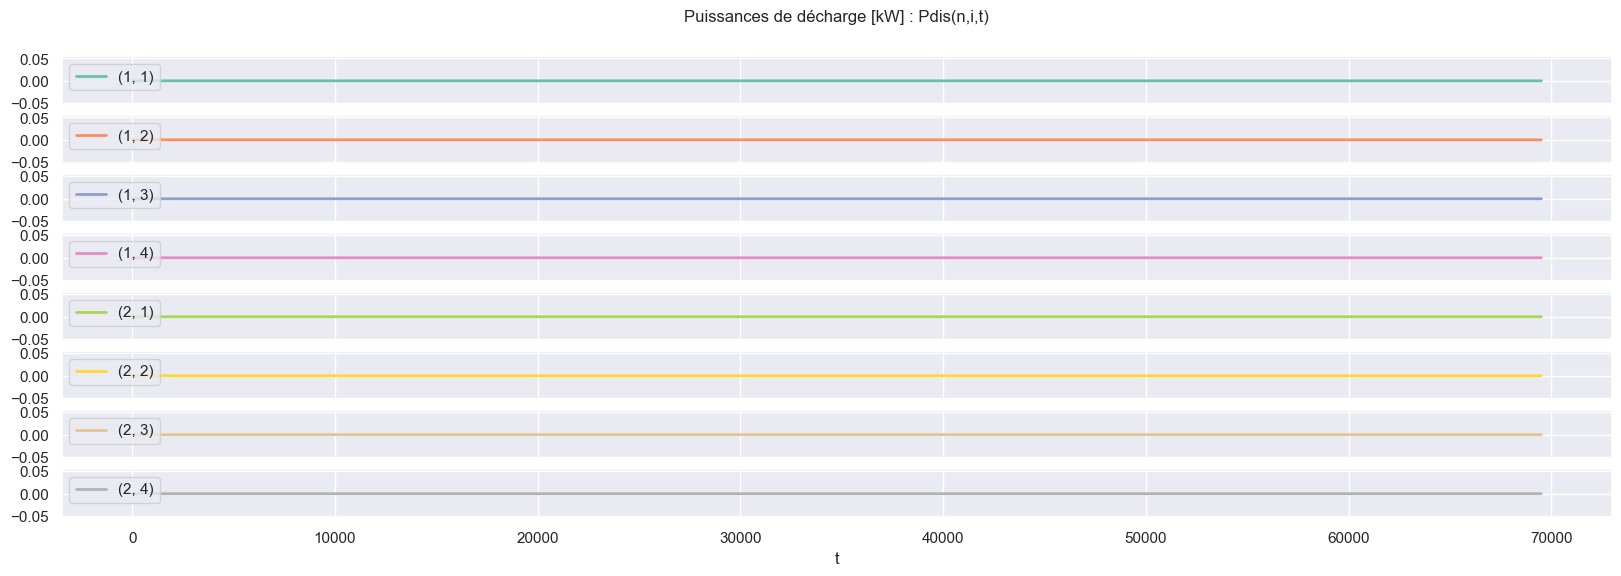

In [176]:
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pdis__n_i_t, index='t', columns=['n', 'i'])
g = df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
g[0].set_title('Puissances de décharge [kW] : Pdis(n,i,t)')
for i in g:
    i.legend(loc='upper left')
print(df_var.max())

In [177]:
mensuel

,Pr,Pess,Em,Cout Infra,Cout Energie,Cout Puissance,Cout Total
0,11153.211,1039.599,4410215.799,13583.923,16891.127,163695.685,194170.734
1,11153.211,1039.599,5164445.449,15847.910,19779.826,163695.685,199323.421
2,11153.211,1039.599,5772909.898,17545.901,22110.245,163695.685,203351.830
3,11153.211,1039.599,5537469.898,16979.904,21208.510,163695.685,201884.098
4,11153.211,1039.599,5772909.898,17545.901,22110.245,163695.685,203351.830
5,11153.211,1039.599,5537469.898,16979.904,21208.510,163695.685,201884.098
6,11153.211,1039.599,5772909.898,17545.901,22110.245,163695.685,203351.830
7,11153.211,1039.599,5772909.898,17545.901,22110.245,163695.685,203351.830
8,11153.211,1039.599,5537469.898,16979.904,21208.510,163695.685,201884.098
9,11153.211,1039.599,5772909.898,17545.901,22110.245,163695.685,203351.830


In [178]:

display(tab)


,Pr,Pess,Em,Cout Infra,Cout Energie,Cout Puissance,total_shift,Cout Total
0,11153.211,0.000,4408199.500,13583.923,16883.404,163695.685,194163.012,194163.012
1,11153.211,0.000,5161603.500,15847.910,19768.941,163695.685,199312.537,199312.537
2,11153.211,0.000,5767226.000,17545.901,22088.476,163695.685,203330.061,203330.061
3,11153.211,0.000,5531786.000,16979.904,21186.740,163695.685,201862.329,201862.329
4,11153.211,0.000,5767226.000,17545.901,22088.476,163695.685,203330.061,203330.061
5,11153.211,0.000,5531786.000,16979.904,21186.740,163695.685,201862.329,201862.329
6,11153.211,0.000,5767226.000,17545.901,22088.476,163695.685,203330.061,203330.061
7,11153.211,0.000,5767226.000,17545.901,22088.476,163695.685,203330.061,203330.061
8,11153.211,0.000,5531786.000,16979.904,21186.740,163695.685,201862.329,201862.329
9,11153.211,0.000,5767226.000,17545.901,22088.476,163695.685,203330.061,203330.061


In [179]:
dk.to_csv(Path(save_dir,'Puissances.csv'))

In [180]:
dk.to_excel(Path(save_dir,'Puissances.xlsx'))